# K-Means

1. Randomly pick k data points as initial Centroids.
2. Compute distance between each data point to each centroid.
3. Assign each data point to the closest centroid based on min distance.
4. New centroid location is avg of all those in current cluster.
5. Repeat the Steps 2 to 4 until centroids don’t change

In [1]:
import numpy as np
from sklearn.datasets import fetch_california_housing
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm

In [120]:
x, y = fetch_california_housing(return_X_y=True)
x = x[:, 0].reshape(-1, 1)

In [121]:
def choose_initial_centroids(x, k, use_random=False, seed=0):
    if use_random:
        centroids = x[np.random.RandomState(0).choice(len(x), k)]
    else:
        xsummed = x.sum(axis=1)
        idxs = np.argsort(xsummed)
        args = np.array([int((i + 1) * len(x) / (k + 1)) for i in range(k)])
        centroids = x[idxs[args]]
    
    return centroids

In [139]:
def compute_distances(x, centroids):
    return np.stack([np.linalg.norm(x - mu, axis=1) for mu in centroids])


def assign_points(distances):
    return distances.argmin(axis=0)


def update_centroids(x, assignments, k):
    centroids = [x[assignments == cluster].mean(axis=0) for cluster in range(k)]
    return np.array(centroids)


def run_step(x, centroids, k):
    distances = compute_distances(x, centroids)
    assignments = assign_points(distances)
    
    centroids = update_centroids(x, assignments, k)
    return centroids


def compute_r(x, centroids):
    k = len(centroids)
    clusters = assign_points(compute_distances(x=x, centroids=centroids))
    r = np.array([[int(i==c) for i in range(k)] for c in clusters])
    assert r.sum() == len(x)
    return r

In [140]:
def loss_fn(x, centroids):
    r = compute_r(x, centroids)
    return np.dot(compute_distances(x, centroids) ** 2, r).sum()

In [147]:
def loss_gradients(x, centroids):
    r = compute_r(x, centroids)
    l = np.dot(compute_distances(x, centroids) ** 2, r)
    
    dL = (np.matmul(r.T, x) - centroids) / l.sum(axis=1).reshape(-1, 1)
    return dL / len(x)

In [148]:
def gradient_descent_step(x, centroids, learning_rate=0.1):
    new_centroids = centroids - learning_rate * loss_gradients(x, centroids)
    loss = loss_fn(x, new_centroids)
    return new_centroids, loss

In [168]:
def run_gradient_descent(x, k, seed=0, learning_rate=0.1, n_steps=1000, use_random_centroids=False):
    """Run the gradient descent loop."""
    centroids = choose_initial_centroids(x, k, use_random=use_random_centroids, seed=seed)

    loss_dict = {-1: loss_fn(x, centroids=centroids)}
    
    for i in tqdm.tqdm(range(n_steps)):
        centroids, loss = gradient_descent_step(x, centroids, learning_rate=learning_rate)
        loss_dict[i] = loss
        
    return centroids, loss_dict

In [173]:
centroids, loss_dict = run_gradient_descent(x, k=6, learning_rate=0.1)
clusters = assign_points(compute_distances(x=x, centroids=centroids))

  0%|          | 0/1000 [00:00<?, ?it/s]

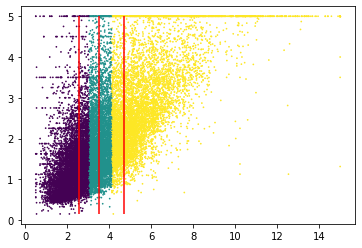

In [170]:
plt.scatter(x, y, c=clusters, s=0.5)
plt.vlines(centroids, ymin=y.min(), ymax=y.max(), colors='red')
plt.show()
plt.close()

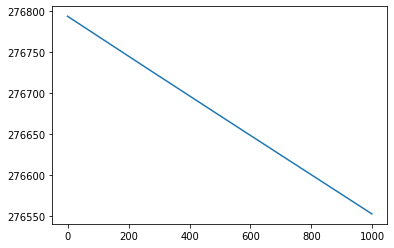

In [171]:
plt.plot(loss_dict.keys(), loss_dict.values())
plt.show()
plt.close()